In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score, r2_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn import linear_model, discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

In [34]:
df = pd.read_csv('Data/diabetes.csv')

In [35]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


In [36]:
df = pd.get_dummies(df, drop_first=True)
df

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,0,False,False,False,False,False,False,False
99996,2.0,0,0,17.37,0,False,False,False,False,False,False,False
99997,66.0,0,0,27.83,0,True,False,False,False,True,False,False
99998,24.0,0,0,35.42,0,False,False,False,False,False,True,False


In [37]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [38]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# KNN

In [39]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de datos
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': range(1, 50), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

random_seach = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=params_grid, n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')

random_seach.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': range(1, 50),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [40]:
random_seach.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 44, 'knn__metric': 'manhattan'}

In [41]:
random_knn = random_seach.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=random_knn, y_true=y_test))

AUC 0.8183055448408871


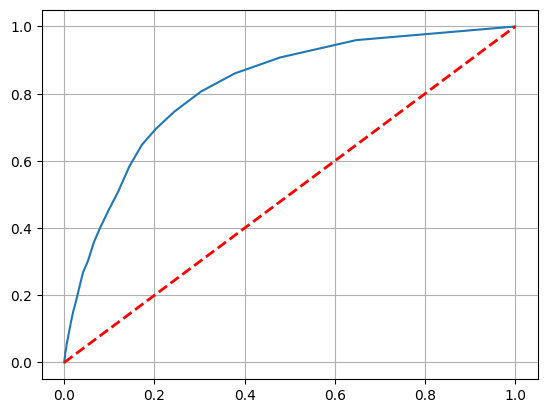

In [87]:
fpr, fnp, scores = roc_curve(y_score=random_knn, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

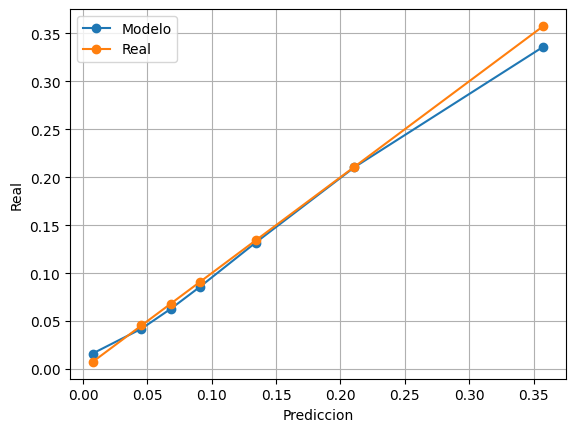

In [42]:
calibracion(random_knn, y_test, 10)

# Regresion Logistica

In [44]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

params_grid = {
    'poly__degree':[1,2,3],
    'logreg__penalty':['l2', None],
    'logreg__C':[0.01, 0.1, 1]
}

In [45]:
log_reg_random = RandomizedSearchCV(estimator=pipeline, cv=5, n_jobs=-1,
                                    scoring='roc_auc',
                                    param_distributions=params_grid,
                                    n_iter=5)

log_reg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [46]:
log_reg_random.best_params_

{'poly__degree': 3, 'logreg__penalty': 'l2', 'logreg__C': 1}

In [47]:
probabilites_log_reg_random = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

print("AUC",roc_auc_score(y_score=probabilites_log_reg_random, y_true=y_test))

AUC 0.8385055287688846


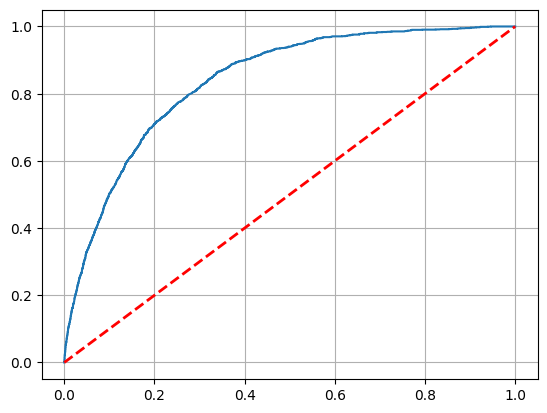

In [88]:
fpr, fnp, scores = roc_curve(y_score=probabilites_log_reg_random, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

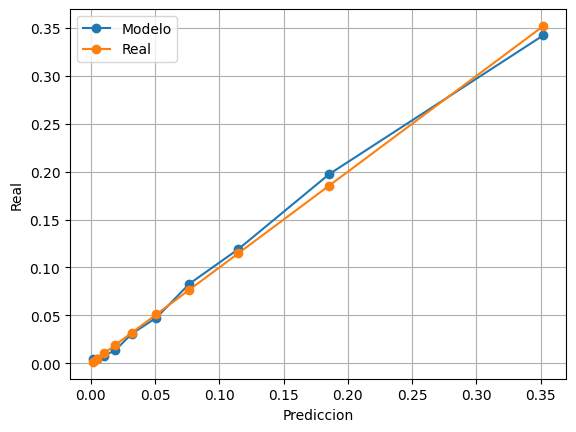

In [48]:
calibracion(probabilites_log_reg_random, y_test, 10)

# Variables regresión logistica

In [50]:
variables = log_reg_random.best_estimator_.named_steps['poly'].get_feature_names_out(X_train.columns)
coeficientes = log_reg_random.best_estimator_.named_steps['logreg'].coef_[0]

model_coeficientes = pd.DataFrame({
          'Variable': variables,
          'Coeficiente': coeficientes
})
model_coeficientes = model_coeficientes.sort_values(by='Coeficiente', ascending=False).head()
model_coeficientes

,Variable,Coeficiente
14,age bmi,1.775520
11,age^2,1.610450
41,bmi^2,0.910702
86,age^2 smoking_history_never,0.806432
19,age smoking_history_former,0.536738


Analizando las variables nos damos que las variables con un mayor coeficiente son age bmi, age^2, bmi^2, age^2 smoking_history_never y age smoking_history_former, lo cual nos indica que en el crecimiento de estas variables sus log odds aumenta, estas son las variables que tienen un impacto más importante para predecir si una persona tiene diabetes o no, podemos ver que en las 5 se involucra age y bmi que nos dice la importancia de estas dos variables en la predicción.

# Analisis del discriminante lineal

In [51]:
pipeline = Pipeline([
    ("scaler",  StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)

probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]
print("AUC", roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test))

AUC 0.8307843137254902


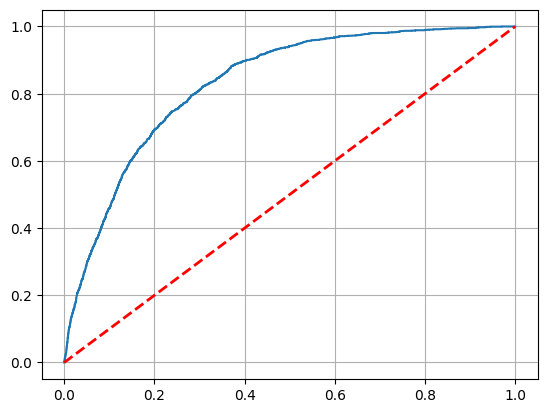

In [89]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

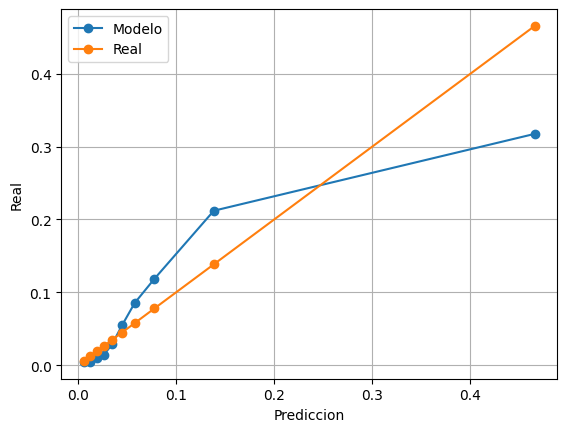

In [52]:
calibracion(probabilidades_modelo_disc, y_test, 10)

# Red Neuronal

In [54]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(max_iter=1000, random_state=42))
])

# Params grid
params_grid = {
     'nn__hidden_layer_sizes': [(50,50,50), (10,), (100,), (10,10)],
     'nn__activation': ['tanh', 'relu', 'logistic'],
     'nn__alpha': [0.1, 0.01]
}

# Fit 
grid_nn = RandomizedSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_distributions=params_grid)

grid_nn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn',
                                              MLPClassifier(max_iter=1000,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01],
                                        'nn__hidden_layer_sizes': [(50, 50, 50),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [55]:
grid_nn.best_params_

{'nn__hidden_layer_sizes': (50, 50, 50),
 'nn__alpha': 0.01,
 'nn__activation': 'logistic'}

In [56]:
nn_predictions = grid_nn.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=nn_predictions, y_true=y_test))

AUC 0.8402341690774672


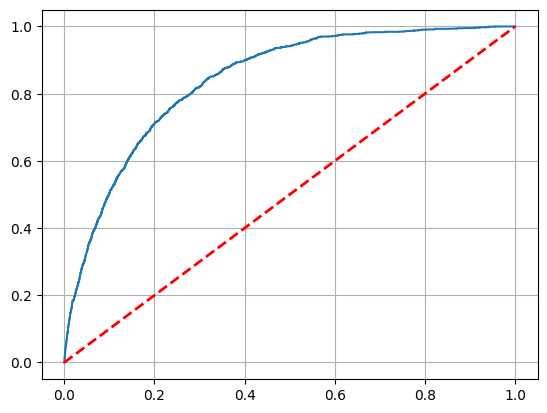

In [90]:
fpr, fnp, scores = roc_curve(y_score=nn_predictions, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

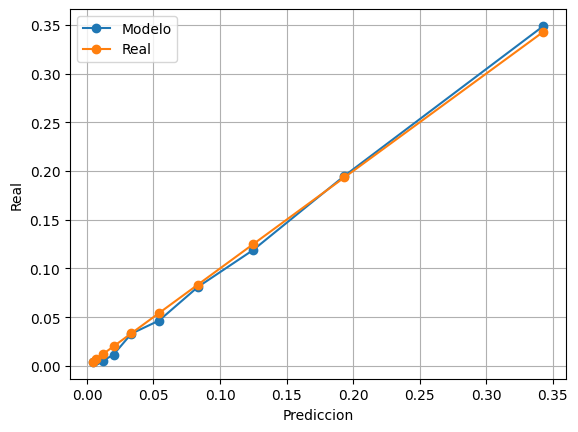

In [57]:
calibracion(nn_predictions, y_test, 10)

In [97]:
juntar = pd.DataFrame({
    'real': y_test,
    'knn': random_knn,
    'Regresion Logistica': probabilites_log_reg_random,
    'Analisis discriminante lineal' : probabilidades_modelo_disc,
    'Red Neuronal' : nn_predictions
})
juntar.head()

,real,knn,Regresion Logistica,Analisis discriminante lineal,Red Neuronal
69456,0,0.000000,0.008050,0.026620,0.016284
86614,0,0.000000,0.015157,0.025268,0.016945
61660,0,0.022727,0.046897,0.043377,0.064120
8558,0,0.045455,0.017581,0.031003,0.020088
4619,0,0.113636,0.127728,0.068178,0.126523


# Histogramas modelos

## Histograma KNN

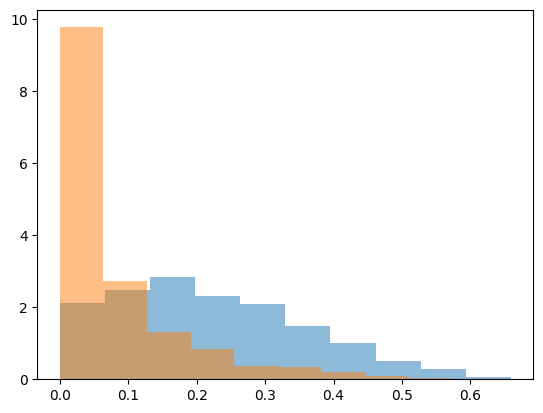

In [100]:
plt.hist(juntar[juntar['real']==1]['knn'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['knn'], density=True, alpha=0.5)
plt.show()

## Histograma Regresion Logistica

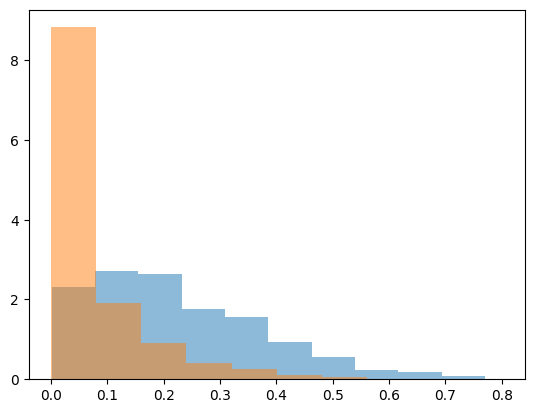

In [101]:
plt.hist(juntar[juntar['real']==1]['Regresion Logistica'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Regresion Logistica'], density=True, alpha=0.5)
plt.show()

## Histograma Analisis discriminante lineal

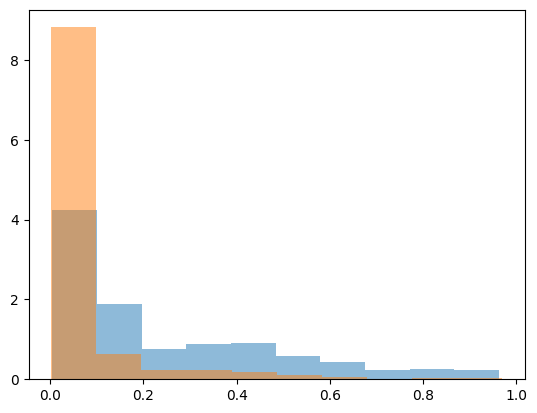

In [102]:
plt.hist(juntar[juntar['real']==1]['Analisis discriminante lineal'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Analisis discriminante lineal'], density=True, alpha=0.5)
plt.show()

## Histograma Red Neuronal

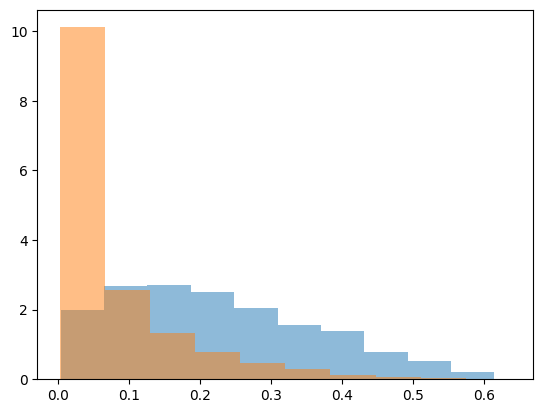

In [103]:
plt.hist(juntar[juntar['real']==1]['Red Neuronal'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Red Neuronal'], density=True, alpha=0.5)
plt.show()

# AUC modelos

In [59]:
auc = pd.DataFrame({
    'knn': [roc_auc_score(y_score=random_knn, y_true=y_test)],
    'Regresion Logistica': [roc_auc_score(y_score=probabilites_log_reg_random, y_true=y_test)],
    'Analisis del discriminante lineal': [roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test)],
    'Red Neuronal': [roc_auc_score(y_score=nn_predictions, y_true=y_test)]
})
auc

,knn,Regresion Logistica,Analisis del discriminante lineal,Red Neuronal
0,0.818306,0.838506,0.830784,0.840234


In [60]:
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False


# Feature Engineering

In [61]:
df['age/bmi'] = df['age'] / df['bmi']
df['age*bmi'] = df['age'] * df['bmi']

df['age^2'] = df['age'] ** 2
df['bmi^2'] = df['bmi'] ** 2
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age/bmi,age*bmi,age^2,bmi^2
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False,3.175863,2015.20,6400.0,634.5361
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False,1.976574,1475.28,2916.0,746.3824
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False,1.024890,764.96,784.0,746.3824
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False,1.535181,844.20,1296.0,549.9025
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False,3.773585,1530.64,5776.0,405.6196


In [62]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# KNN Feature Eng

In [63]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de datos
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': range(1, 50), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

random_seach = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=params_grid, n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')

random_seach.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': range(1, 50),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [64]:
random_seach.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 48, 'knn__metric': 'manhattan'}

In [65]:
random_knn_fe = random_seach.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=random_knn_fe, y_true=y_test))

AUC 0.8214745258759242


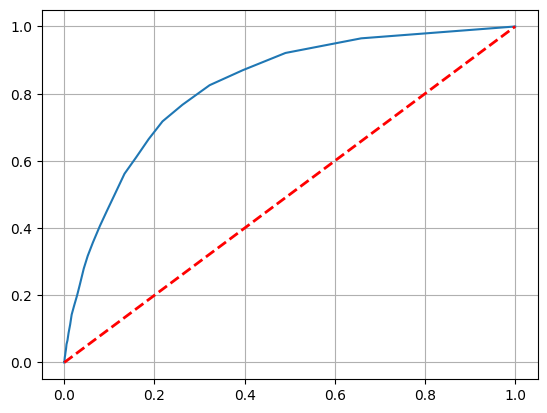

In [91]:
fpr, fnp, scores = roc_curve(y_score=random_knn_fe, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

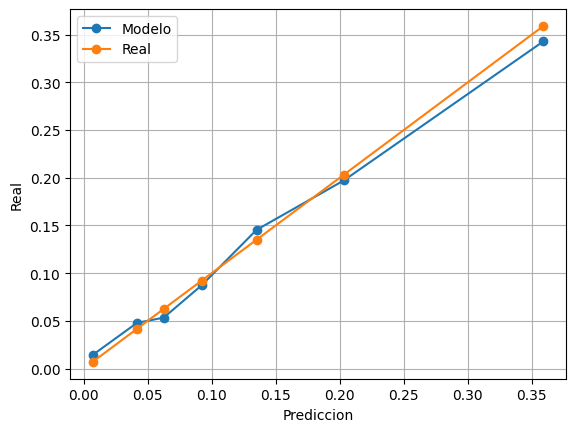

In [67]:
calibracion(random_knn_fe, y_test, 10)

# Regresion Logistica Feature Eng

In [68]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

params_grid = {
    'poly__degree':[1,2,3],
    'logreg__penalty':['l2', None],
    'logreg__C':[0.01, 0.1, 1]
}

In [69]:
log_reg_random = RandomizedSearchCV(estimator=pipeline, cv=5, n_jobs=-1,
                                    scoring='roc_auc',
                                    param_distributions=params_grid,
                                    n_iter=5)

log_reg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [70]:
log_reg_random.best_params_

{'poly__degree': 2, 'logreg__penalty': 'l2', 'logreg__C': 1}

In [71]:
probabilites_log_reg_random_feature_eng = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

print("AUC",roc_auc_score(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test))

AUC 0.8397507553841208


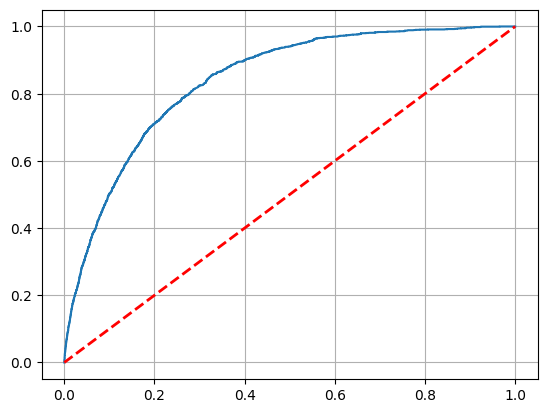

In [92]:
fpr, fnp, scores = roc_curve(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

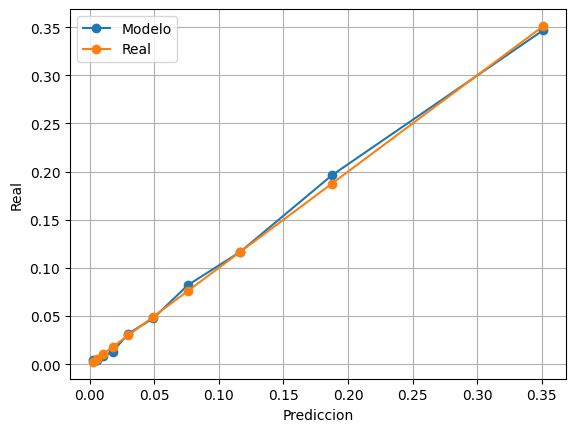

In [72]:
calibracion(probabilites_log_reg_random_feature_eng, y_test, 10)

# Variables regresion logistica feature eng

In [74]:
variables = log_reg_random.best_estimator_.named_steps['poly'].get_feature_names_out(X_train.columns)
coeficientes = log_reg_random.best_estimator_.named_steps['logreg'].coef_[0]

model_coeficientes = pd.DataFrame({
          'Variable': variables,
          'Coeficiente': coeficientes
})
model_coeficientes = model_coeficientes.sort_values(by='Coeficiente', ascending=False).head()
model_coeficientes

,Variable,Coeficiente
118,smoking_history_never age^2,0.678503
12,age*bmi,0.602813
18,age bmi,0.602813
128,age/bmi bmi^2,0.602813
66,bmi age*bmi,0.560743


Analizando las variables al igual que sin hacer feature eng notamos que las que tienen un mayor coeficiente son las que involucran edad y bmi, de nuevo indicando la importancia de estas dos variables en la predicción de que si una persona tiene diabetes o no.

# Analisis del discriminante lineal feature eng

In [75]:
pipeline = Pipeline([
    ("scaler",  StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)

probabilidades_modelo_disc_fe = pipeline.predict_proba(X_test)[:, 1]
print("AUC", roc_auc_score(y_score=probabilidades_modelo_disc_fe, y_true=y_test))

AUC 0.837023818707811


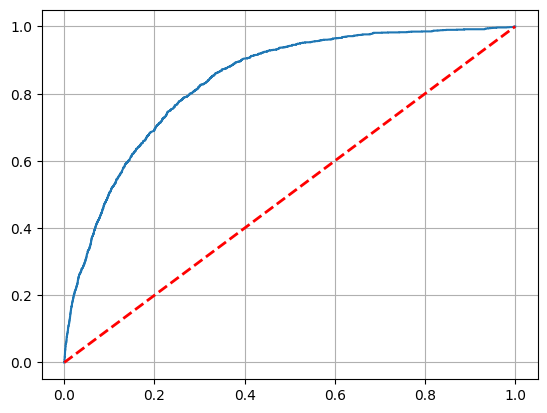

In [93]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc_fe, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

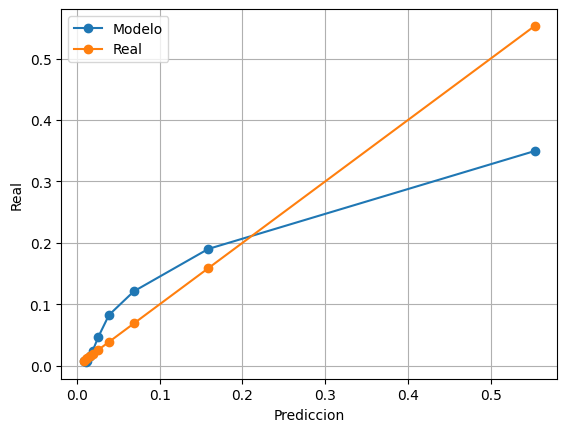

In [76]:
calibracion(probabilidades_modelo_disc_fe, y_test, 10)

# Red Neuronal Feature Eng

In [78]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(max_iter=1000, random_state=42))
])

# Params grid
params_grid = {
     'nn__hidden_layer_sizes': [(50,50,50), (10,), (100,), (10,10)],
     'nn__activation': ['tanh', 'relu', 'logistic'],
     'nn__alpha': [0.1, 0.01]
}

# Fit 
grid_nn = RandomizedSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_distributions=params_grid)

grid_nn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn',
                                              MLPClassifier(max_iter=1000,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01],
                                        'nn__hidden_layer_sizes': [(50, 50, 50),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [79]:
grid_nn.best_params_

{'nn__hidden_layer_sizes': (10,), 'nn__alpha': 0.1, 'nn__activation': 'tanh'}

In [80]:
nn_predictions_fe = grid_nn.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=nn_predictions_fe, y_true=y_test))

AUC 0.8391412086145934


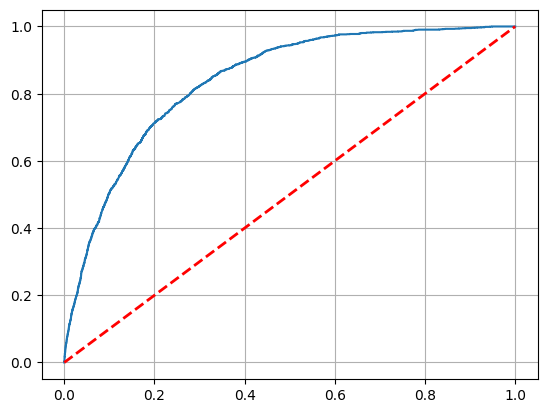

In [94]:
fpr, fnp, scores = roc_curve(y_score=nn_predictions_fe, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

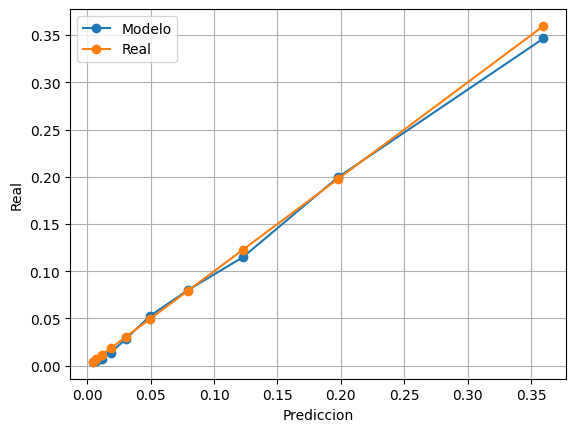

In [81]:
calibracion(nn_predictions_fe, y_test, 10)

# Histograma Modelos Feature Eng

In [104]:
juntar = pd.DataFrame({
    'real': y_test,
    'knn_fe': random_knn_fe,
    'Regresion Logistica FE': probabilites_log_reg_random_feature_eng,
    'Analisis discriminante lineal FE' : probabilidades_modelo_disc_fe,
    'Red Neuronal FE' : nn_predictions_fe
})
juntar.head()

,real,knn_fe,Regresion Logistica FE,Analisis discriminante lineal FE,Red Neuronal FE
69456,0,0.020833,0.010381,0.014439,0.016262
86614,0,0.000000,0.015653,0.014424,0.016828
61660,0,0.041667,0.049948,0.022747,0.070624
8558,0,0.041667,0.017780,0.016450,0.019528
4619,0,0.104167,0.129081,0.048606,0.131368


## Histograma KNN Feature Eng 

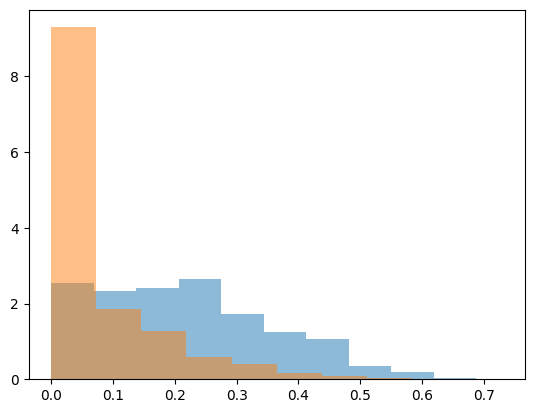

In [105]:
plt.hist(juntar[juntar['real']==1]['knn_fe'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['knn_fe'], density=True, alpha=0.5)
plt.show()

## Histograma Regresion Logistica FE

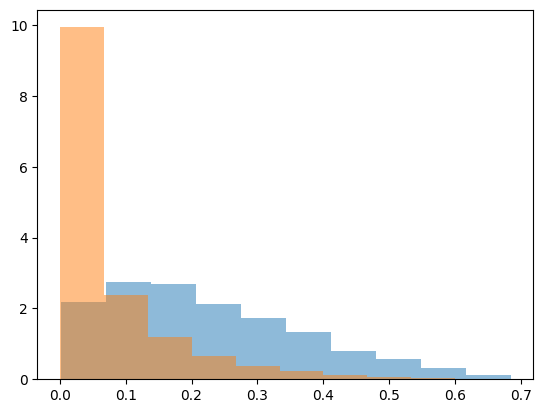

In [106]:
plt.hist(juntar[juntar['real']==1]['Regresion Logistica FE'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Regresion Logistica FE'], density=True, alpha=0.5)
plt.show()

## Histograma Analisis discriminante lineal FE

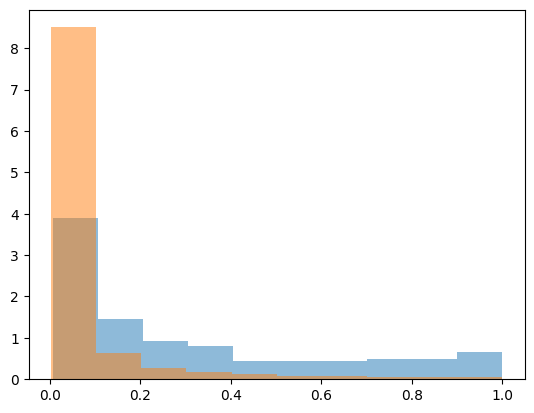

In [107]:
plt.hist(juntar[juntar['real']==1]['Analisis discriminante lineal FE'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Analisis discriminante lineal FE'], density=True, alpha=0.5)
plt.show()

## Histograma Red Neuronal FE

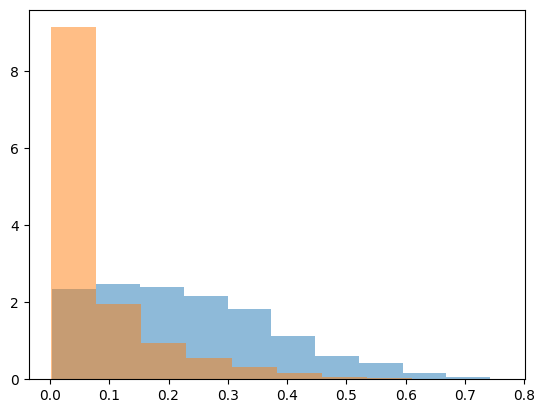

In [108]:
plt.hist(juntar[juntar['real']==1]['Red Neuronal FE'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Red Neuronal FE'], density=True, alpha=0.5)
plt.show()

# AUC Modelos Feature Eng

In [83]:
auc = pd.DataFrame({
    'knn': [roc_auc_score(y_score=random_knn_fe, y_true=y_test)],
        'Regresion Logistica': [roc_auc_score(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test)],
    'Analisis del discriminante lineal': [roc_auc_score(y_score=probabilidades_modelo_disc_fe, y_true=y_test)],
    'Red Neuronal': [roc_auc_score(y_score=nn_predictions_fe, y_true=y_test)]
})
auc

,knn,Regresion Logistica,Analisis del discriminante lineal,Red Neuronal
0,0.821475,0.839751,0.837024,0.839141


# Conclusiones

Para este dataset lo que buscamos es encontrar el mayor AUC de un grupo de personas con diabates, lo que queremos ver es con que modelo existe una mayor probabilidad de que una persona que tiene diabetes tenga una predicción mayor a una la que no.
Sin aplicar feature engineering haciendo los modelos, el modelo con el AUC mayor fue el de la red neuronal con 0.8402 o con un 84.02% de probabilidad de que una persona con diabetes tenga una predicción mayor a la que no.

Posteriormente se crearon cuatro variables nuevas, al solamente tener edad y bmi como varaibles numericas no había mucha posibilidad de jugar con las variables y crear unas nuevas lo cual limitaba el feature eng, al volver a realizar los modelos, se llego a la conclusión de que el mejor modelo en este caso fue la regresion Logistica con un 0.8397 o 83.97% de probabilidad de que una persona con diabetes tenga una predicción mayor a una a la que no lo tiene.

Analizando los histogramas podemos notar que los datos de la gente clasificada como 0 o sin diabetes estan bastante concentradas alrededor del cero, mientras que los que estan clasificados como 1 o con diabetes se distribuyen mucho más alrededor del histograma.

En general el mejor modelo fue la red neuronal con un AUC de 0.8402 sin aplicar feature eng, como ya se menciono anteriormente solo existian dos variables numericas lo cual hizo el feature eng mas limitado y en este caso no mejoro el AUC de los modelos.
